# Annex GG – Quantitative Evaluation of Metal Artifact Reduction (MAR)

This notebook demonstrates a complete **Annex GG-style test procedure** using the `mar-eval` toolkit.

**Purpose:**  Evaluate the detectability improvement achieved by a Metal Artifact Reduction (MAR) algorithm using a Channelized Hotelling Observer (CHO) and Area Under the ROC Curve (AUC) as the figure of merit.

Each section mirrors the logical flow described in **IEC 60601-2-44 Ed. 4 Annex GG (203.6.7.101.4.1.6)**:

1.  **Test Data Generation**  – Create simulated lesion-present / lesion-absent decision values (CHO outputs)
2.  **Model Observer Evaluation** – Generate distributions representing MAR and non-MAR image sets
3.  **AUC Computation and Confidence Intervals** – Estimate detectability and statistical stability
4.  **Statistical Comparison (ΔAUC)** – Compute bias-adjusted performance difference and significance
5.  **Bias Assessment and Visualization** – Plot ROC curves and summarize results

In [1]:
import numpy as np
rng = np.random.default_rng(123)

# Binary lesion labels: 0 = absent, 1 = present
labels = np.concatenate([np.zeros(200), np.ones(200)])

# CHO decision values (synthetic distributions)
no_mar = rng.normal(0, 1.0, 400)
with_mar = rng.normal(0.25, 1.0, 400)  # modest improvement due to MAR

## 1 – Test Data Generation

We simulate 400 cases (200 lesion-absent + 200 lesion-present).  MAR-processed data are modeled with a small mean shift, indicating improved signal separation.

## 2 – Model Observer Evaluation

Decision values correspond to CHO test statistics (*t*) for each image realization.  In a physical test, these would be computed from the reconstructed image sets using the CHO template defined in Annex GG.

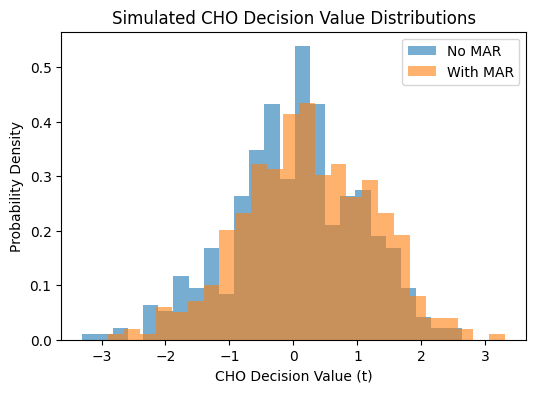

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(no_mar, bins=25, alpha=0.6, label='No MAR', density=True)
plt.hist(with_mar, bins=25, alpha=0.6, label='With MAR', density=True)
plt.xlabel('CHO Decision Value (t)')
plt.ylabel('Probability Density')
plt.title('Simulated CHO Decision Value Distributions')
plt.legend();

## 3 – AUC Computation and Confidence Intervals

Use `compute_auc()` from `mareval.stats` to estimate the Area Under the ROC Curve (AUC) and its 95 % bootstrap confidence interval.

In [4]:
from mareval.stats import compute_auc

res_nomar = compute_auc(no_mar, labels)
res_mar   = compute_auc(with_mar, labels)

print(f"AUC (no MAR): {res_nomar['auc']:.3f}  CI = ({res_nomar['ci'][0]:.3f}, {res_nomar['ci'][1]:.3f})")
print(f"AUC (with MAR): {res_mar['auc']:.3f}  CI = ({res_mar['ci'][0]:.3f}, {res_mar['ci'][1]:.3f})")

AUC (no MAR): 0.484  CI = (0.423, 0.538)
AUC (with MAR): 0.504  CI = (0.445, 0.558)


## 4 – Statistical Comparison (ΔAUC and p-Value)

Apply `compare_auc()` to compute the AUC difference (ΔAUC = AUC<sub>MAR</sub> − AUC<sub>No MAR</sub>) and a paired one-tailed *t*-test, consistent with Annex GG § 203.6.7.101.4.1.6 (*p < 0.05* indicates significant improvement).

In [5]:
from mareval.stats import compare_auc
cmp = compare_auc(with_mar, no_mar, labels)

print(f"ΔAUC = {cmp['delta_auc']:.3f}")
print(f"One-tailed p = {cmp['p_value']:.4f}")

ΔAUC = 0.020
One-tailed p = 0.0046


## 5 – Bias Assessment and ROC Visualization

Visualize ROC curves for MAR and non-MAR conditions to qualitatively confirm detectability improvement.

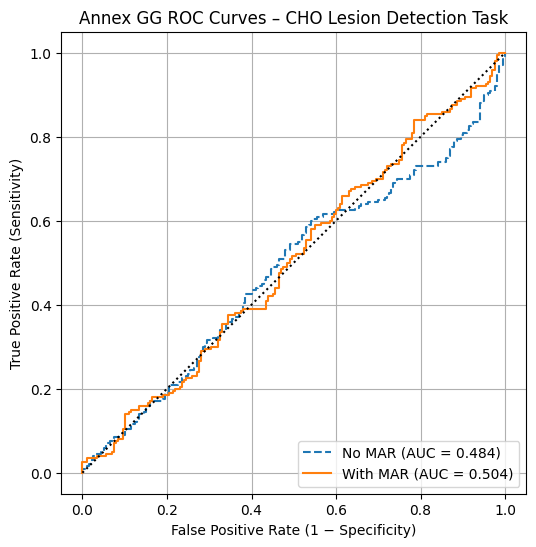

In [6]:
from sklearn.metrics import roc_curve

fpr0, tpr0, _ = roc_curve(labels, no_mar)
fpr1, tpr1, _ = roc_curve(labels, with_mar)

plt.figure(figsize=(6,6))
plt.plot(fpr0, tpr0, '--', label=f'No MAR (AUC = {res_nomar["auc"]:.3f})')
plt.plot(fpr1, tpr1, '-', label=f'With MAR (AUC = {res_mar["auc"]:.3f})')
plt.plot([0,1],[0,1],'k:')
plt.xlabel('False Positive Rate (1 − Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Annex GG ROC Curves – CHO Lesion Detection Task')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### ✅ Interpretation

| Metric | Definition | Typical Interpretation |
|:--|:--|:--|
| AUC | CHO-based lesion detectability | Higher → better visibility |
| ΔAUC | Bias-adjusted MAR improvement | Positive → MAR improves performance |
| p | One-tailed significance | < 0.05 → Statistically significant |

This workflow produces quantitative metrics that can be cited directly in compliance with **IEC 60601-2-44 Ed. 4 (203.6.7.101.4.1.6 – Data Evaluation)** and **Annex GG**, allowing reproducible validation of MAR algorithms.